In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.linear_model
from matplotlib import rcParams
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.metrics import precision_recall_curve, roc_curve, auc, roc_auc_score, precision_score, recall_score, f1_score

<font face="微软雅黑" size=4 color=#A52A2A > 调整格式

In [2]:
config = {
        "mathtext.fontset": 'stix',
        "font.family": 'serif',
        "font.serif": ['SimHei'],
        "font.size": 10,
        'axes.unicode_minus': False
    }
rcParams.update(config)

<font face="微软雅黑" size=4 color=#A52A2A >logistic_regression类

In [3]:
class logistic_regression(object):
    def __init__(self,x_data,y_data):
        self.X = x_data
        self.Y = y_data
        self.alpha = 0.01
        self.iters = 100000

    def initialize(self,X,Y):
        self.__init__(X, Y)

    def sigmoid(self,z):
        return 1 / (1 + np.exp(-z))

    def computeCost(self,X,Y,W):
        P = self.sigmoid(np.dot(X,W))
        loss = np.sum(-Y*np.log(P) - (1-Y)*np.log(1-P)) /X.shape[0]
        return loss,P

    def gradientDecent(self,W, X, Y):
        error = self.sigmoid(np.dot(X,W)) - Y
        grad = np.dot(X.T, error) / X.shape[0]
        W -= self.alpha * grad
        return W

    def logisticRegression(self,X, Y, alpha, iters):
        feature_dim = X.shape[1]
        W = np.zeros((feature_dim, 1))
        W_his = []
        loss_his = []
        for i in range(self.iters):
            loss,P = self.computeCost(X, Y, W)
            loss_his.append(loss)
            W_his.append(W.copy())
            W = self.gradientDecent(W, X, Y)
        return loss_his, W,W_his

    def testmodel(self,X,Y,W_his,iters):
        test_loss = []
        for i in W_his:
            loss,p = self.computeCost(X,Y,i)
            test_loss.append(loss)
        return test_loss

<font face="微软雅黑" size=4 color=#A52A2A >读取数据

In [4]:
path = pd.read_csv("D:\\qq.file\\ex2data1.txt",header=None,names=['x1','x2','y'])
cols = path.shape[1]
x_data = path.iloc[:,:cols - 1]
y_data = path.iloc[:,cols-1:]
x=x_data.values
y=y_data.values

<font face="微软雅黑" size=4 color=#A52A2A >数据散点图

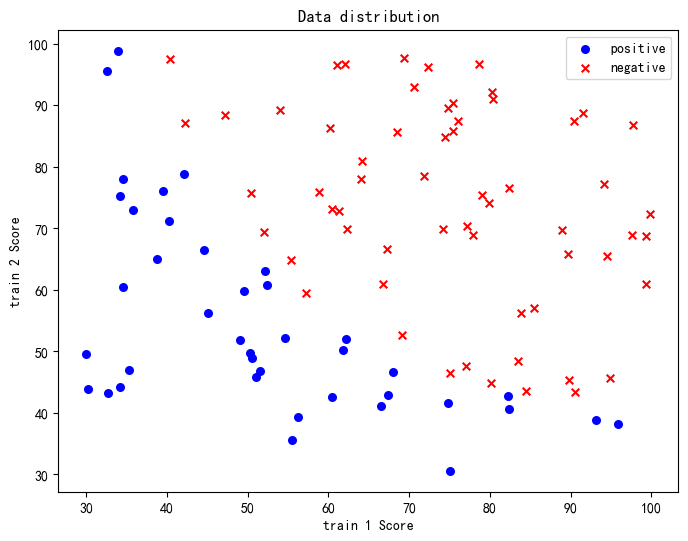

In [5]:
fig,ax = plt.subplots(figsize=(8,6))
ax.scatter(x[y[:,0]==0][:,0], x[y[:,0]==0][:,1], s=30, c='b', marker='o', label='positive')
ax.scatter(x[y[:,0]==1][:,0], x[y[:,0]==1][:,1], s=30, c='r', marker='x', label='negative')
plt.legend()
plt.xlabel('train 1 Score')
plt.ylabel('train 2 Score')
plt.title('Data distribution')
plt.show()

<font face="微软雅黑" size=4 color=#A52A2A > 数据归一化

In [6]:
scaler = MinMaxScaler()
normalized_x_data = scaler.fit_transform(x)
Y = scaler.fit_transform(y)
ones = np.ones((normalized_x_data.shape[0], 1))
X = np.concatenate((ones, normalized_x_data), axis=1)

<font face="微软雅黑" size=4 color=#A52A2A >创建对象

In [7]:
loss_his_sum = []
test_loss_his_sum = []
W_sum = []
precision_sum = []
recall_sum = []
f1_sum = []
fpr_sum = []
tpr_sum = []
auc_sum = 0
x = logistic_regression(X, Y)

<font face="微软雅黑" size=4 color=#A52A2A >k折交叉验证

In [8]:
kfold = KFold(n_splits=5,shuffle=True,random_state=42)
for train_index,test_index in kfold.split(X):
    ##数据划分
    this_train_x,this_train_y = X[train_index],Y[train_index]
    this_test_x,this_test_y = X[test_index],Y[test_index]
    
    ##得到loss_his，W_his,test_loss_his
    x.initialize(this_train_x, this_train_y)
    loss_his, W,W_his= x.logisticRegression(x.X, x.Y, x.alpha, x.iters)
    test_loss = x.testmodel(this_test_x,this_test_y,W_his,x.iters)

    loss_his_sum.append(loss_his)
    test_loss_his_sum.append(test_loss)
    W_sum.append(W)

    ##得到precision,recall,f1,fpr,tpr,auc
    test_pre = x.sigmoid(np.dot(this_test_x, W))
    test_prediction = (test_pre >= 0.5).astype(int)
    prediction = precision_score(this_test_y, test_prediction)
    recall = recall_score(this_test_y, test_prediction)
    f1 = f1_score(this_test_y, test_prediction)
    fpr, tpr, _ = roc_curve(this_test_y, test_pre)
    roc_auc = auc(fpr,tpr)

    precision_sum.append(prediction)
    recall_sum.append(recall)
    f1_sum.append(f1)
    fpr_sum.append(fpr)
    tpr_sum.append(tpr)
    auc_sum += roc_auc

<font face="微软雅黑" size=4 color=#A52A2A >计算平均的loss,test_loss,precision,recall,f1,fpr,tpr,auc

In [9]:
loss_ave = np.mean(loss_his_sum,axis=0)
test_loss_ave = np.mean(test_loss_his_sum,axis=0)

precision_avg = np.mean(precision_sum)
recall_avg = np.mean(recall_sum)
f1_avg = np.mean(f1_sum)
fpr_avg = np.linspace(0.0, 1.0, 100)
tpr_avg = np.zeros_like(fpr_avg)
for i in range(5):
    tpr_avg += np.interp(fpr_avg, fpr_sum[i], tpr_sum[i])
fpr_avg = np.insert(fpr_avg, 0, 0.0)
tpr_avg = np.insert(tpr_avg, 0, 0.0)
tpr_avg = tpr_avg / 5
auc_avg = auc_sum / 5

<font face="微软雅黑" size=4 color=#A52A2A >画出训练和测试曲线

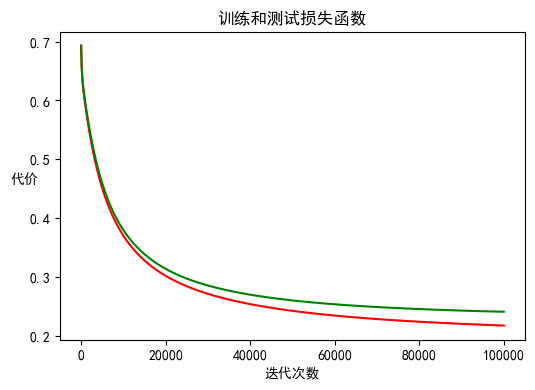

In [10]:
plt.figure(figsize=(6, 4))
plt.plot(np.arange(len(loss_ave)), loss_ave, 'r',label='训练集损失函数')
plt.plot(np.arange(len(test_loss_ave)), test_loss_ave, 'g',label='测试集损失函数')
plt.xlabel('迭代次数')
plt.ylabel('代价', rotation=0)
plt.title('训练和测试损失函数')
plt.show()


<font face="微软雅黑" size=4 color=#A52A2A >画出平均ROC曲线

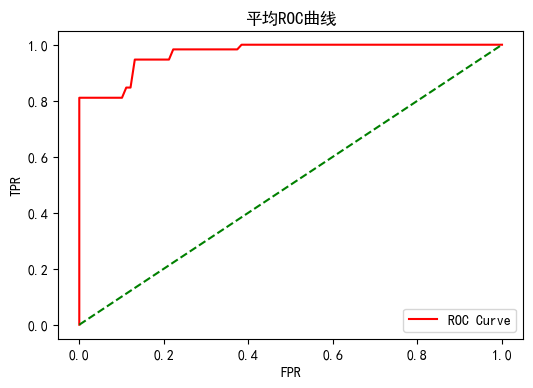

In [11]:
plt.figure(figsize=(6, 4))
plt.plot(fpr_avg, tpr_avg, 'r', label='ROC Curve')
plt.plot([0, 1], [0, 1], 'g', linestyle='--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('平均ROC曲线')
plt.legend()
plt.show()

<font face="微软雅黑" size=4 color=#A52A2A >模型评价

In [12]:
print(precision_avg)
print(recall_avg)
print(f1_avg)
print(auc_avg)

0.9038095238095238
0.9008658008658008
0.8993727689379863
0.9691287878787879
